In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

data=load_breast_cancer()
X=data.data
y=data.target

In [3]:
X_train, X_test, y_train, y_test=train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 455
Test size: 114


In [9]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [10]:
from sklearn.svm import SVC

svm_rbf=SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svm_rbf.fit(X_train_scaled, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred=svm_rbf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

Accuracy: 0.9824561403508771

Confusion Matrix:
[[41  1]
 [ 1 71]]

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [13]:
y_scores=svm_rbf.decision_function(X_test_scaled)

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score

for threshold in[-1.0, 0, 1.0]:
    y_pred_thresh=(y_scores>=threshold).astype(int)

    print(f"\nThreshold:{threshold}")
    print(confusion_matrix(y_test, y_pred_thresh))
    print("Recall:", recall_score(y_test, y_pred_thresh))
    print("Precision:", precision_score(y_test, y_pred_thresh))


Threshold:-1.0
[[32 10]
 [ 0 72]]
Recall: 1.0
Precision: 0.8780487804878049

Threshold:0
[[41  1]
 [ 1 71]]
Recall: 0.9861111111111112
Precision: 0.9861111111111112

Threshold:1.0
[[42  0]
 [22 50]]
Recall: 0.6944444444444444
Precision: 1.0


In [15]:
y_scores=svm_rbf.decision_function(X_test_scaled)

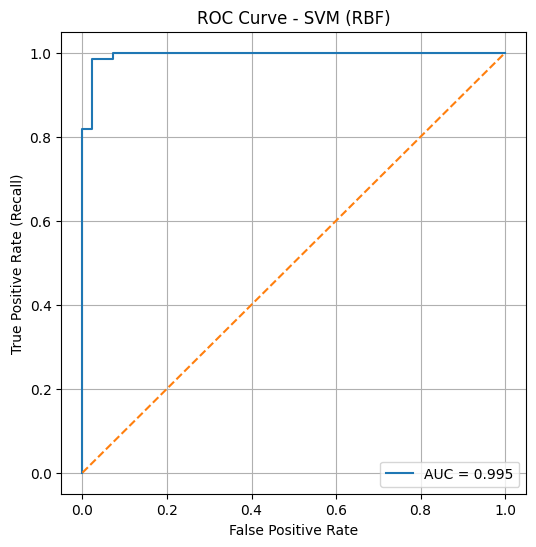

AUC Score: 0.9950396825396826


In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds=roc_curve(y_test, y_scores)
roc_auc=auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - SVM (RBF)")
plt.legend()
plt.grid(True)
plt.show()

print("AUC Score:", roc_auc)

In [19]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores=cross_val_score(
    svm_rbf,
    X_train_scaled,
    y_train,
    cv=skf,
    scoring="recall"
)

print("CV Recall scores:", cv_scores)
print("Mean CV Recall:", cv_scores.mean())

CV Recall scores: [0.98245614 0.96491228 0.94736842 0.98245614 1.        ]
Mean CV Recall: 0.9754385964912281


In [20]:
from sklearn.model_selection import GridSearchCV

param_grid={
    "C":[0.1, 1, 10],
    "gamma":[0.01, 0.1, 1],
    "kernel":["rbf"]
}

grid=GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring="recall",
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV Recall:", grid.best_score_)

Best parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Best CV Recall: 1.0


In [21]:
best_svm = grid.best_estimator_

y_pred_best = best_svm.predict(X_test_scaled)

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=data.target_names))

[[ 0 42]
 [ 0 72]]
              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00        42
      benign       0.63      1.00      0.77        72

    accuracy                           0.63       114
   macro avg       0.32      0.50      0.39       114
weighted avg       0.40      0.63      0.49       114



C:\Users\ASUS\OneDrive\Desktop\Ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\OneDrive\Desktop\Ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ASUS\OneDrive\Desktop\Ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

In [22]:
from sklearn.metrics import make_scorer, recall_score
recall_malignant=make_scorer(recall_score, pos_label=0)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    "C": [0.1, 1, 10],
    "gamma": [0.01, 0.1, 1],
    "kernel": ["rbf"]
}

grid_correct = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    scoring=recall_malignant,
    cv=5,
    n_jobs=-1
)

grid_correct.fit(X_train_scaled, y_train)

print("Best parameters (malignant recall):", grid_correct.best_params_)
print("Best CV Recall (malignant):", grid_correct.best_score_)

Best parameters (malignant recall): {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV Recall (malignant): 0.9588235294117646


In [24]:
best_svm_correct = grid_correct.best_estimator_

y_pred_correct = best_svm_correct.predict(X_test_scaled)

from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_correct))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_correct, target_names=data.target_names))

Confusion Matrix:
[[41  1]
 [ 4 68]]

Classification Report:
              precision    recall  f1-score   support

   malignant       0.91      0.98      0.94        42
      benign       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

